In [307]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
from scipy.sparse import csr_matrix
from scipy.sparse import vstack, hstack
import seaborn as sns
import lightgbm as lgb

%matplotlib inline

sns.set_theme()

In [40]:
usecols = [
    "id",
    "place_name",
    "place_country",
    "latitude",
    "longitude"
]

In [41]:
total_users = pd.read_pickle("../../../../dosT/ffunes/total_users_parsed.pkl")

In [42]:
total_users = total_users.loc[:, usecols]

In [43]:
total_users.shape

(176029, 5)

In [44]:
usecols = [
    "user_id",
    "hashtags",
    #"mentions_country"
]

In [45]:
users_with_hashtags = pd.read_pickle("../../../../dosT/ffunes/users_with_hashtags_limited.pkl")

In [46]:
users_with_hashtags = users_with_hashtags.loc[:, usecols]

In [47]:
users_with_hashtags.head()

,user_id,hashtags
0,189288089,"[lucha, sueños, reflexion]"
1,1309297526,"[brasilia, masterchef, masterchefbr]"
2,164544337,[play]
3,147691812,[tbt]
4,1053287509,[viña2019]


In [48]:
users_with_hashtags.shape

(70435, 2)

In [49]:
users_train = pd.merge(
    left=total_users,
    right=users_with_hashtags,
    how='inner',
    left_on='id',
    right_on='user_id',
    validate='1:1'
)
del users_train['user_id']

In [50]:
users_train.head()

,id,place_name,place_country,latitude,longitude,hashtags
0,189288089,kissimmee,estados unidos,28.304680,-81.416672,"[lucha, sueños, reflexion]"
1,1309297526,caldas novas,brasil,-17.744310,-48.627892,"[brasilia, masterchef, masterchefbr]"
2,164544337,curitiba,brasil,-25.427780,-49.273060,[play]
3,147691812,asuncion,paraguay,-25.286461,-57.646999,[tbt]
4,1053287509,machalí,chile,-34.180820,-70.649330,[viña2019]


In [51]:
users_train.shape

(70435, 6)

In [52]:
users_train.loc[:, ['hashtags']] = users_train["hashtags"].apply(lambda l: list(map(str, l)))

In [53]:
users_train["unified_place"] = users_train["place_name"] + ',' + users_train["place_country"]

# Función para calcular distancias entre datos predecidos y reales

In [290]:
geonames.loc[geonames["alternatenames"] == "ciudad autonoma de buenos aires", :]["latitude"]

15000   -34.613152
Name: latitude, dtype: float64

In [296]:
geonames = pd.read_pickle("../../../../dosT/ffunes/geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

'''def accuracy_161km(predicted_place, real_place):
    pred_city, pred_country = predicted_place.split(',')
    real_city, real_country = real_place.split(',')
    
    pred = geonames.loc[geonames["alternatenames"] == pred_city and geonames["country"] == pred_country, :]
    
    real = geonames.loc[geonames["alternatenames"] == real_city and geonames["country"] == real_country, :]
    
    distance = haversine_distance(pred["latitude"], pred["longitude"], real["latitude"], real["longitude"])
    '''
    

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

def accuracy_161km(real_place, pred_place):
    dif_distance = get_difference_distance(pred_place, real_place)
    
    total_positives = 0
    
    for val in dif_distance:
        if val <= 161:
            total_positives += 1
    
    return total_positives / len(dif_distance)

# Predicciones

In [228]:
min_determined_place = users_train.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

In [229]:
min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 528, :]

In [230]:
min_determined_place.shape

(23, 2)

In [231]:
users_train_selected = pd.merge(
    left=users_train,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)
users_train_selected.shape

(33677, 7)

In [232]:
total_users = users_train_selected["id"].apply(lambda l: str(l)).values

In [233]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    #min_df=50
)

vector_of_hashtags = vectorizer.fit_transform(users_train_selected["hashtags"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_hashtags

<33677x6937 sparse matrix of type '<class 'numpy.int64'>'
	with 278823 stored elements in Compressed Sparse Row format>

In [234]:
total_hashtags = len(vectorizer.vocabulary_)

Train with hashtags

In [235]:
#users_train_final = users_train_selected.sample(frac=1, random_state=4503493)
users_complete_location = users_train_selected.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_selected['unified_place'].unique())

In [317]:
estimators = [
    {
        "name": "LightGBM",
        "estimator": lgb.LGBMClassifier(n_jobs=1, objective="multiclass", random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, -1], 'class_weight': ['balanced']}
    },    
    {
        "name": "SVC",
        "estimator": SVC(kernel="rbf", probability=True, random_state=1500),
        "params_grid": {"C": [1, 10, 100], "gamma": [.01, .1]}
    },
    {
        "name": "DecisionTree",
        "estimator": DecisionTreeClassifier(random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
    },
    {
        "name": "RandomForest",
        "estimator": RandomForestClassifier(n_jobs=-1, random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
    }
]

In [318]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=44540570)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=45405450)

In [ ]:
scores = {}
predictions = {}

for estimator in estimators:
    clf = GridSearchCV(
        estimator=estimator["estimator"],
        param_grid=estimator["params_grid"],
        cv=inner_cv,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo'],
        refit='roc_auc_ovo'
    )
    
    nested_score = cross_validate(
        clf,
        X=vector_of_hashtags.astype('float'),
        y=users_complete_location[:,0],
        cv=outer_cv,
        n_jobs=-1,
        scoring={
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'roc_auc_ovo': 'roc_auc_ovo',
            'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
        }
    )
    
    nested_predict = cross_val_predict(
        clf,
        X=vector_of_hashtags.astype('float'),
        y=users_complete_location[:,0],
        cv=outer_cv,
        n_jobs=-1,
        method='predict'
    )
        
    scores[estimator["name"]] = nested_score
    predictions[estimator["name"]] = nested_predict

In [324]:
scores

{'LightGBM': {'fit_time': array([343.69879365, 342.97962999, 340.69858789, 345.50074482,
         347.14118099]),
  'score_time': array([ 9.51502728,  8.59453845, 11.5201447 ,  7.25386667,  5.86082864]),
  'test_accuracy': array([0.31695368, 0.31695368, 0.31655531, 0.31640683, 0.30734967]),
  'test_balanced_accuracy': array([0.34145942, 0.34838058, 0.34103652, 0.33573139, 0.32667634]),
  'test_roc_auc_ovo': array([0.79852153, 0.80510031, 0.80243267, 0.80215803, 0.79768358]),
  'test_accuracy@161': array([0.4864905 , 0.47817696, 0.47720861, 0.48685969, 0.46978471])},
 'SVC': {'fit_time': array([5300.72946715, 5397.85531163, 5388.16789174, 5416.47131491,
         5395.09116626]),
  'score_time': array([35.1685884 , 35.73703146, 38.64642978, 34.09420657, 34.09099269]),
  'test_accuracy': array([0.51751781, 0.52360451, 0.51314031, 0.5199703 , 0.50883445]),
  'test_balanced_accuracy': array([0.2647133 , 0.27712572, 0.26064107, 0.27224981, 0.25957122]),
  'test_roc_auc_ovo': array([0.7667048

In [338]:
df = pd.DataFrame(
    {
        "estimator": scores.keys(),
        "accuracy": [x["test_accuracy"] for x in scores.values()],
        "balanced_acc": [x["test_balanced_accuracy"] for x in scores.values()],
        "roc_auc": [x["test_roc_auc_ovo"] for x in scores.values()],
        "accuracy@161": [x["test_accuracy@161"] for x in scores.values()],
    }
)

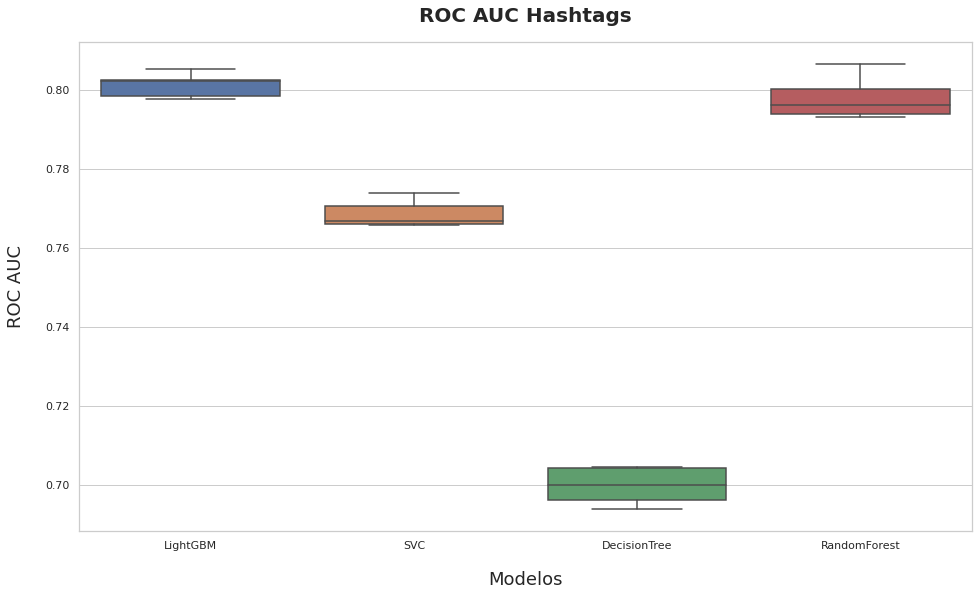

In [359]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(
    x="estimator",
    y="roc_auc",
    data=df.explode("roc_auc"),
    ax=ax
)

ax.set_title("ROC AUC Hashtags", fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel("Modelos", fontsize=18, labelpad=20)
ax.set_ylabel("ROC AUC", fontsize=18, labelpad=20)

sns.set_theme()

In [373]:
best_params = {}

for estimator in estimators:
    clf = GridSearchCV(
        estimator=estimator["estimator"],
        param_grid=estimator["params_grid"],
        cv=inner_cv,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo'],
        refit='roc_auc_ovo'
    )
    
    clf.fit(vector_of_hashtags.astype('float'), users_complete_location[:,0])
    
    best_params[estimator["estimator"]] = clf.best_params_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [374]:
best_params

{LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=1, num_leaves=31,
                objective='multiclass', random_state=1500, reg_alpha=0.0,
                reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0): {'class_weight': 'balanced',
  'max_depth': 80},
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=1500, shrinking=True, tol=0.001,
     verbose=False): {'C': 10, 'gamma': 0.01},
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        mi

In [312]:
distances_predicted = get_difference_distance(
    predictions['RandomForest'],
    users_complete_location[:,0]
)

Total NaN:  0


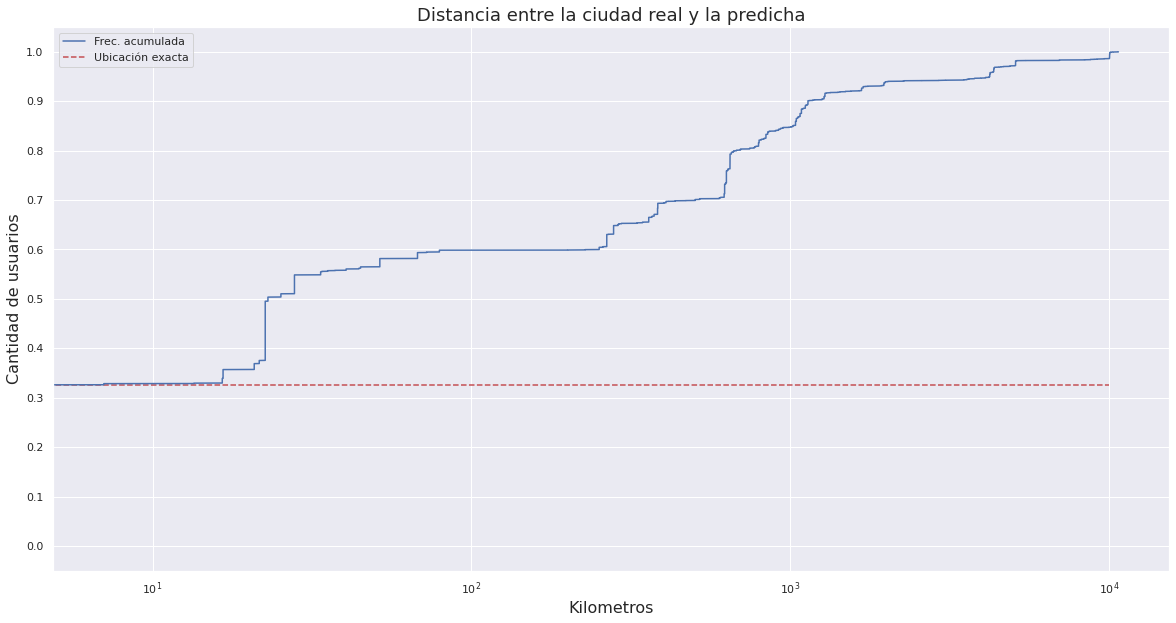

In [313]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(users_complete_location[:,0], predictions['RandomForest']), -200, 10000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

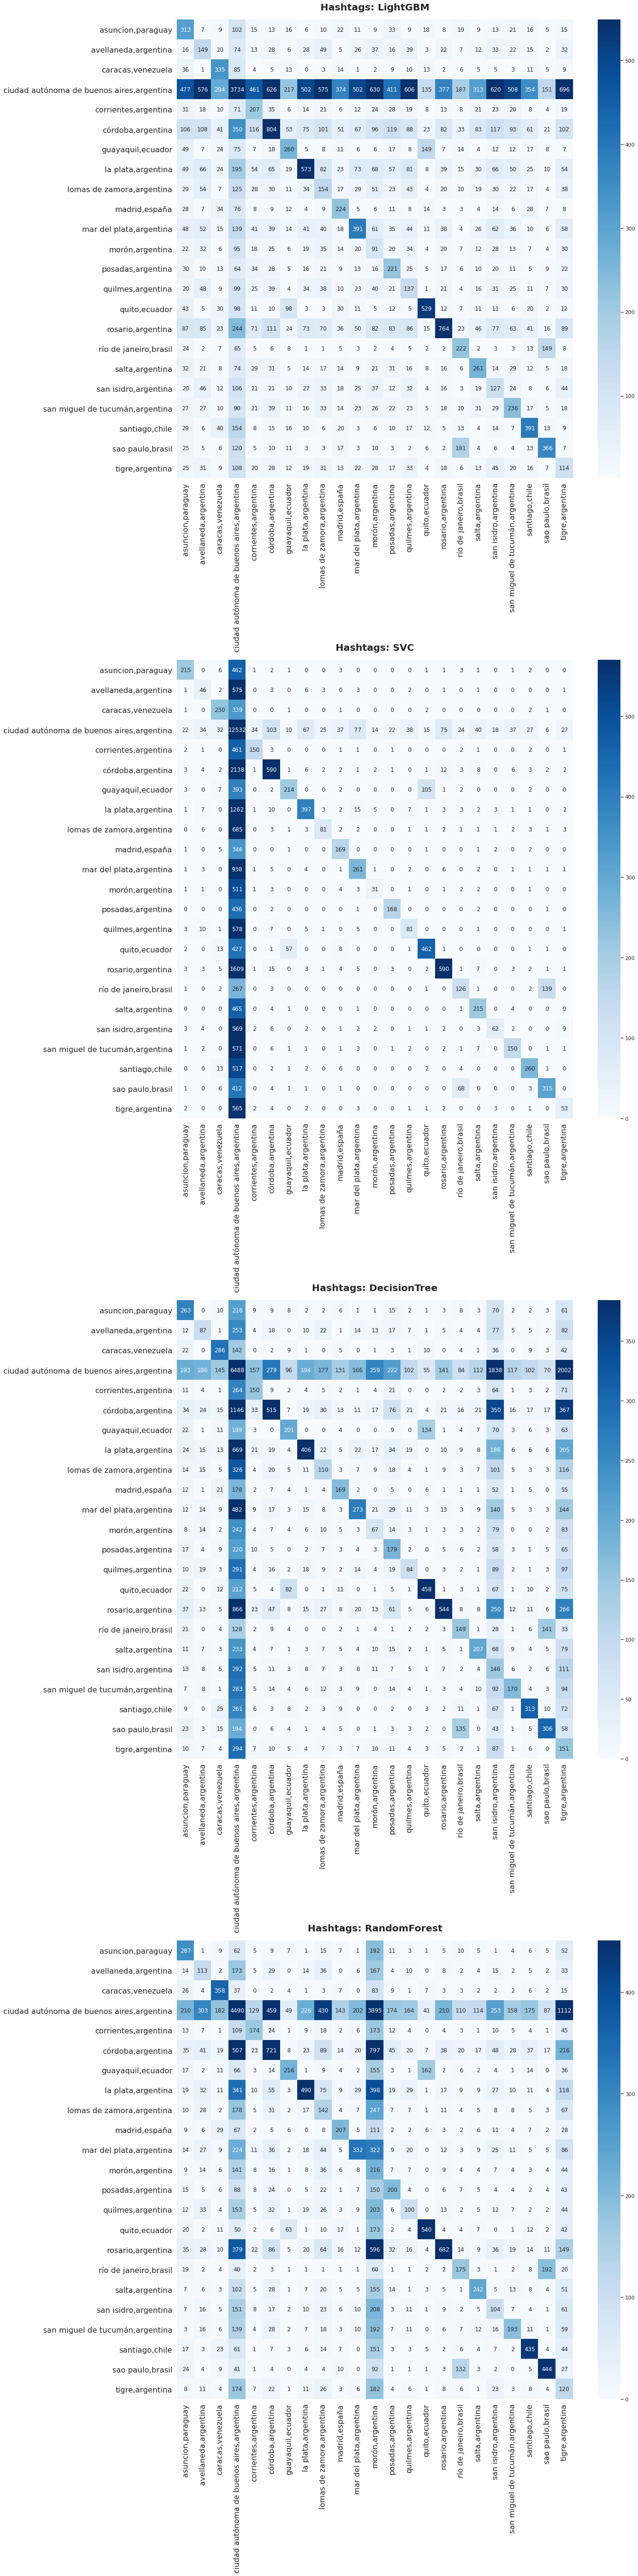

In [369]:
f, ax = plt.subplots(nrows=len(predictions), figsize=(25, 20*len(predictions)))
i = 0
f.tight_layout(pad=30.0)

for key in predictions:
    cm = confusion_matrix(users_complete_location[:,0], predictions[key], labels=class_names)

    sns.heatmap(
        cm,
        annot=True,
        #linewidths=.5,
        fmt='d',
        robust=True,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax[i]
    )
    
    ax[i].set_title("Hashtags: " + key, fontsize=20, fontweight='bold', pad=20)
    ax[i].xaxis.set_tick_params(labelsize=16)
    ax[i].yaxis.set_tick_params(labelsize=16)

    i += 1

In [23]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_hashtags, users_complete_location[:,0], test_size=0.30)

In [24]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [25]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
            'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'min_samples_leaf': 1, 'class_weight': 'balanced', 'max_depth': 200} 0.3375060498448045


In [26]:
y_predicted = grid_drop.predict(X_test)

In [27]:
accuracy_score(y_test, y_predicted)

0.4179877732877422

In [28]:
balanced_accuracy_score(y_test, y_predicted)

0.26789452930974084

Test using  oslom and similiraty within users using hashtags

In [24]:
fake_nodes = csr_matrix((total_hashtags, total_hashtags), dtype=np.int64)
fake_nodes

<10321x10321 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [25]:
vector_of_fake_hashtags = vstack([fake_nodes, vector_of_hashtags])

In [26]:
vector_of_fake_hashtags

<42490x10321 sparse matrix of type '<class 'numpy.int64'>'
	with 243886 stored elements in Compressed Sparse Row format>

In [27]:
vector_of_common_hashtags = vector_of_fake_hashtags.dot(vector_of_fake_hashtags.T)
vector_of_common_hashtags.setdiag(0, k=0)

/var/home/ffunes/venv/lib/python3.5/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [28]:
vector_of_common_hashtags

<42490x42490 sparse matrix of type '<class 'numpy.longlong'>'
	with 49127292 stored elements in Compressed Sparse Row format>

In [29]:
cx = vector_of_common_hashtags.tocoo()
edges = []

temp_values = -1
temp_vecinity = -1

passed = True
last_one = -1

for i,j,v in zip(cx.row, cx.col, cx.data):
    if last_one != i:        
        if not passed and temp_values > 0:
            format_str = str(last_one) + " " + str(temp_vecinity) + " " + str(temp_values)
            edges.append(format_str)
            
        last_one = i
        passed = False    
        temp_values = -1
        temp_vecinity = -1
    
    if v <= 5:
        if v > temp_values:
            temp_values = v
            temp_vecinity = j
        continue
        
    passed = True
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

len(edges)

KeyboardInterrupt: 

In [31]:
cx = vector_of_common_hashtags.tocoo()
edges = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v >= 5:
        format_str = str(i) + " " + str(j) + " " + str(v)
        edges.append(format_str)

len(edges)

1197666

In [116]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../edges_hashtags_weighted.csv", header=False, index=False)

In [23]:
import re
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    clusters = {}
    hashtag_clusters = {}
    data = []
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                clusters[cluster] = l
                for i in l:
                    if not i in hashtag_clusters:
                        hashtag_clusters[i] = set()
                    hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["user_id", "cluster"]), hashtag_clusters

In [ ]:
!cd ../oslom/OSLOM2 && \
./oslom_dir -f ../../edges_hashtags_weighted.csv -w -fast -seed 430430 -cp 0.5

setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../edges_hashtags_weighted.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 49084802 factorials...
done
mkdir: cannot create directory ‘../../edges_hashtags_weighted.csv_oslo_files’: File exists
output files will be written in directory: ../../edges_hashtags_weighted.csv_oslo_files
network:: 31862 nodes and 4.90848e+07 stubs;	 average degree = 1540.54
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 1364
collection done 


checked 0 modules 0 were found significant.  Modules to check: 432. Percentage nodes done: 0


In [25]:
train, clusters = extract_oslom('../edges_hashtags_weighted.csv_oslo_files/tp')

def get_original_user_id(row):
    return total_users[row["user_id"] - total_hashtags]

In [26]:
train["real_user_id"] = train.apply(get_original_user_id, axis=1)

In [27]:
train["real_user_id"] = train.real_user_id.astype(int)

In [28]:
train

,user_id,cluster,real_user_id
0,10510,0,48591606
1,10625,0,322153975
2,10705,0,85494941
3,11031,0,247463940
4,11213,0,166454910
5,11302,0,251840290
6,11562,0,543392682
7,11686,0,2533487641
8,11779,0,2866442920
9,11805,0,133477784


In [29]:
users_train_final = pd.merge(
    left=train,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="id",
    validate="m:1"
)

In [30]:
users_train_final = users_train_final.loc[:, ["real_user_id", "cluster", "unified_place", "latitude", "longitude"]]

In [31]:
users_train_final = users_train_final.groupby(
    ["real_user_id", "unified_place", "latitude", "longitude"]
)['cluster'].apply(list).reset_index(name='clusters')

In [32]:
users_train_final.shape

(31862, 5)

In [33]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [34]:
users_train_final = users_train_final.loc[:, ["clusters"]]
users_train_final["clusters"] = users_train_final["clusters"].apply(lambda l: list(map(str, l)))

In [35]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    token_pattern=r"(?u)\b\w+\b"
)

vector_of_clusters = vectorizer.fit_transform(users_train_final["clusters"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_clusters  

<31862x672 sparse matrix of type '<class 'numpy.int64'>'
	with 41272 stored elements in Compressed Sparse Row format>

In [36]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_clusters, users_complete_location[:,0], test_size=0.30)

In [37]:
decisiontree = RandomForestClassifier(n_jobs=2)
decisiontree.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [38]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
            'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'max_depth': None, 'min_samples_leaf': 1, 'class_weight': 'balanced'} 0.14356766113491815


In [39]:
y_predicted = grid_drop.predict(X_test)

In [40]:
accuracy_score(y_test, y_predicted)

0.14488963280677894

In [41]:
balanced_accuracy_score(y_test, y_predicted)

0.19313816364798844

In [42]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


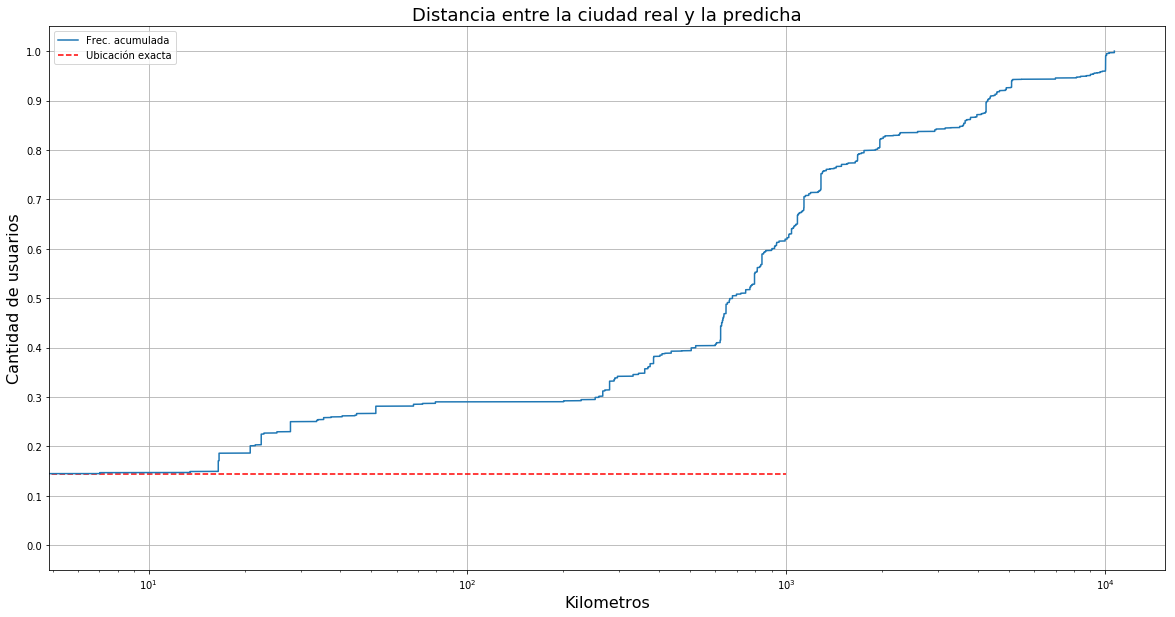

In [43]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

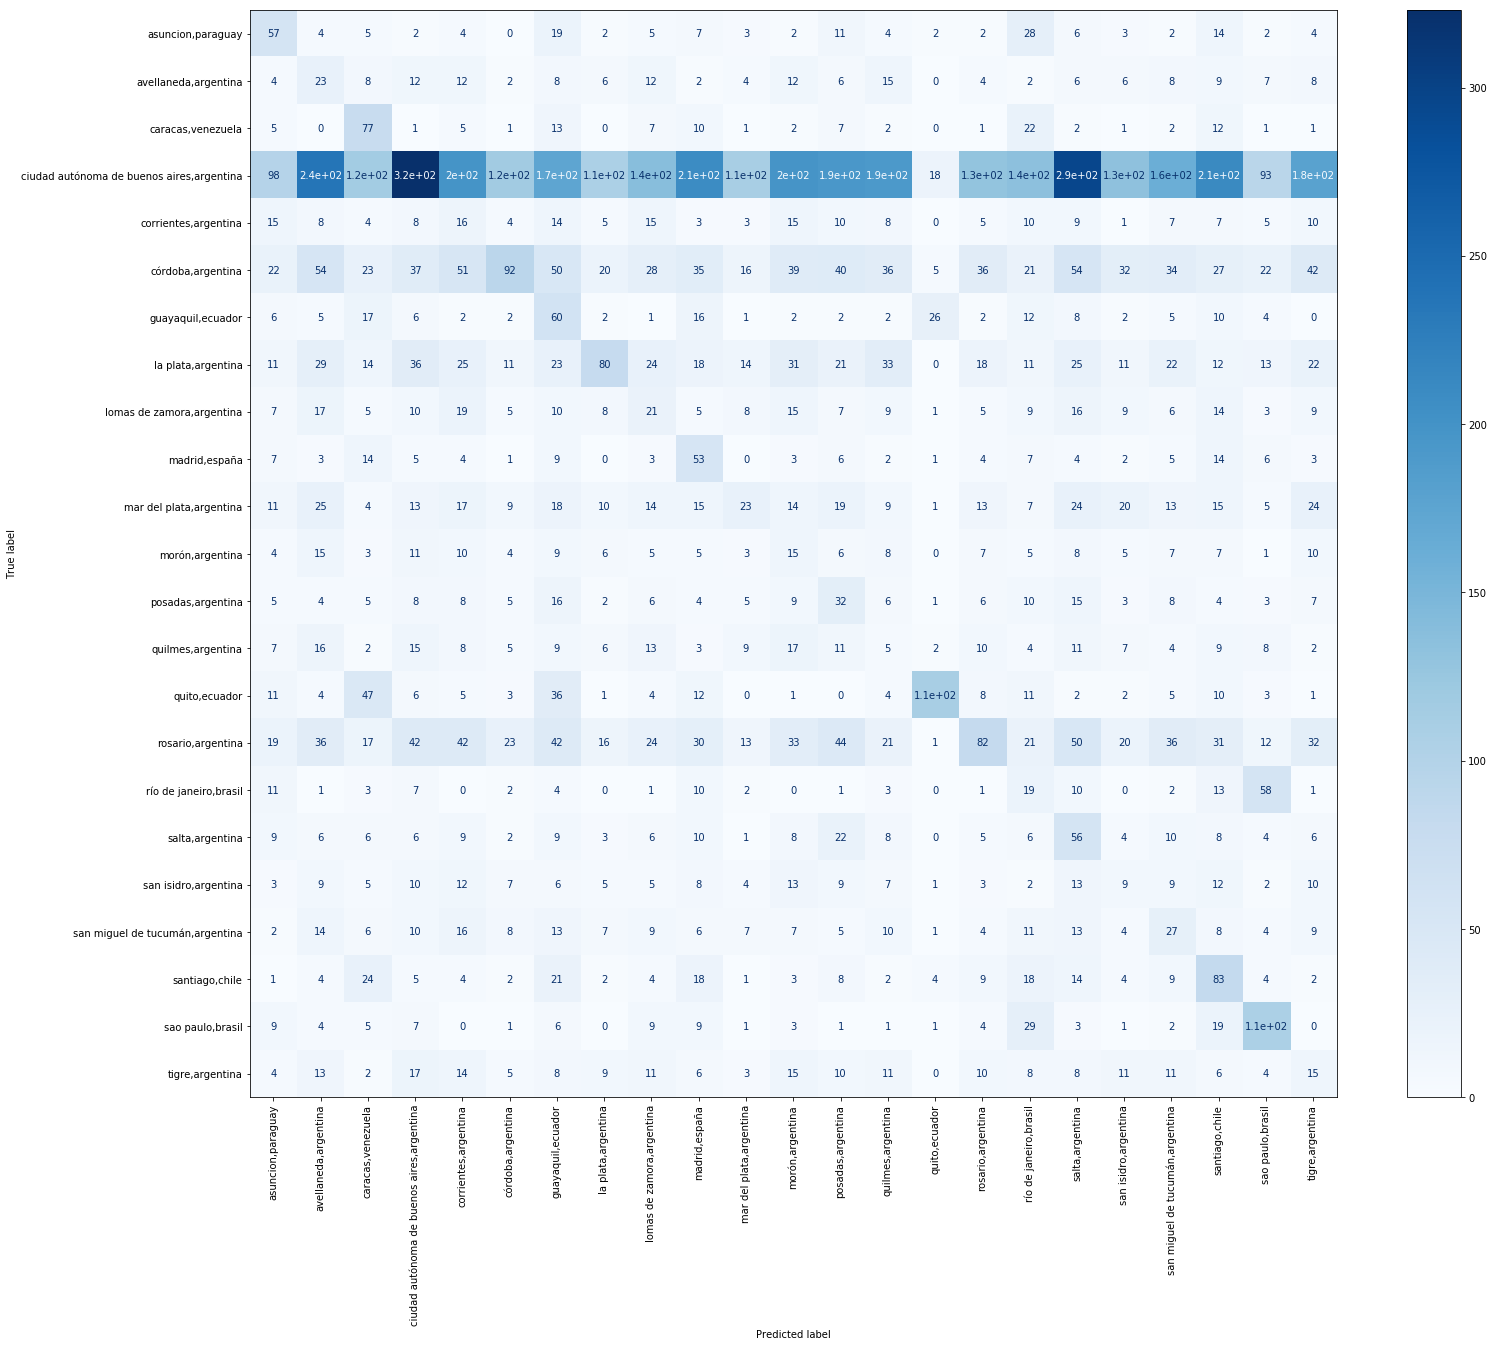

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)